# Lattice Proteins Notebook. 
LP are artificial protein sequences, used here to benchmark the algorithm against ground truth knowledge of the structure and of the fitness function

## Loading data and packages

/users/tubiana/anaconda/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/users/tubiana/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/users/tubiana/anaconda/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/users/tubiana/anaconda/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/users/tubiana/anaconda/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may i

First sequence numerical encoding
[ 3  8  0 10 12  0 10  2 12  2 10  0  6  3  6  8  8  8  7 14  0 18 10  4
  3  5  3]
Corresponding Amino-Acids:
EKAMPAMDPDMAHEHKKKIRAWMFEGE


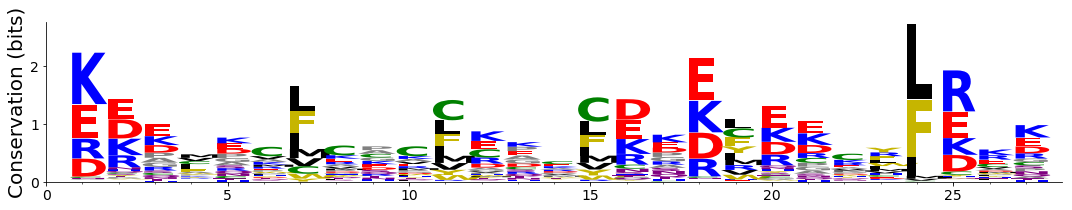

In [ ]:
%matplotlib inline
import sys,os,pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('RBM/')
sys.path.append('utilities/')

try:
    import rbm
except:
    print 'Compiling cy_utilities first' # the RBM package contains cython files that must be compiled first.
    curr_dir = os.getcwd()
    os.chdir('RBM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    import rbm


import Proteins_utils, Proteins_RBM_utils, utilities,sequence_logo,plots_utils






filename = 'Lattice_Proteins_MSA.fasta'
filename_pnat = 'Lattice_Proteins_pnat.txt'
path = u'data/Lattice_Proteins/'

all_data = Proteins_utils.load_FASTA(path+filename)
all_pnat = np.asarray(pd.read_csv(path+filename_pnat,sep=' ',header=None))[:,0]


data = all_data[:-10000]
logpnat = np.log(all_pnat[:-10000])
data_test = all_data[-10000:]
logpnat_test = np.log(all_pnat[-10000:])


weights = None
weights_test = None

print 'First sequence numerical encoding'
print all_data[0]
print 'Corresponding Amino-Acids:'
print Proteins_utils.num2seq(all_data)[0]

mu = utilities.average(all_data,c=21,weights=None)
sequence_logo.Sequence_logo(mu,ticks_every=5,figsize=(15,3));

Sequences have high probability to fold into $S_A$. $S_G$ is one of the main competing structures.

![](Figure_Lattice_Proteins.png)

## Learning

In [ ]:
make_training = True

n_v = 27 # Number of visible units; = # sites in alignment.
n_h = 100 # Number of hidden units.
visible = 'Potts' # Nature of visible units potential. Here, Potts states...
n_cv = 20 # With n_cv = 20 colors (all possible amino acids)
hidden = 'dReLU' # Nature of hidden units potential. Here, dReLU potential.
seed = 0 # Random seed (optional)

if make_training:
    RBM = rbm.RBM(visible = visible,hidden = hidden,n_v = n_v,n_h = n_h, n_cv = n_cv, random_state = seed)
    batch_size = 100 # Size of mini-batches (and number of Markov chains used). Default: 100.
    n_iter = 100 # Number of epochs
    learning_rate = 0.1 # Initial learning rate (default: 0.1)
    decay_after = 0.5 # Decay learning rate after 50% of iterations (default: 0.5)
    l1b = 0.025 # L1b regularization. Default : 0.
    N_MC = 5 # Number of Monte Carlo steps between each update
    
    RBM.fit(data, weights= weights, batch_size = batch_size,
            n_iter = n_iter, l1b = l1b, N_MC = N_MC, 
           decay_after = decay_after, verbose = 0 )
    
else:
    RBM = Proteins_RBM_utils.loadRBM('models/RBM_Lattice_Proteins_A.data') ## Alternative: Load previous model.

Starting epoch 1
Starting epoch 2
Starting epoch 3


## Evaluate accuracy of training: Train and test set likelihood

In [ ]:
RBM.AIS(n_betas=20000,verbose=1) # Compute partition function with annealed importance sampling

print RBM.likelihood(data).mean()/27, RBM.likelihood(data_test).mean()/27


## Visualizing hidden units: Sequence logo of weights
Show sequence logos of some selected weights.
- Feature 1: Two different realizations of the contact 3-26. Either electrostatic (top amino-acids, negative amino-acid at 3 and positive at 26), or hydrophobic).
- Feature 2: A triangle of three neighboring sites.
- Feature 3: Four sites on the upper face of Structure A.
- Feature 4: Two joint realizations of the triangle 1-18-20 and the contact 3-26. 1 and 26 must have identical charges to destabilize Structure G, in which they are in contact.

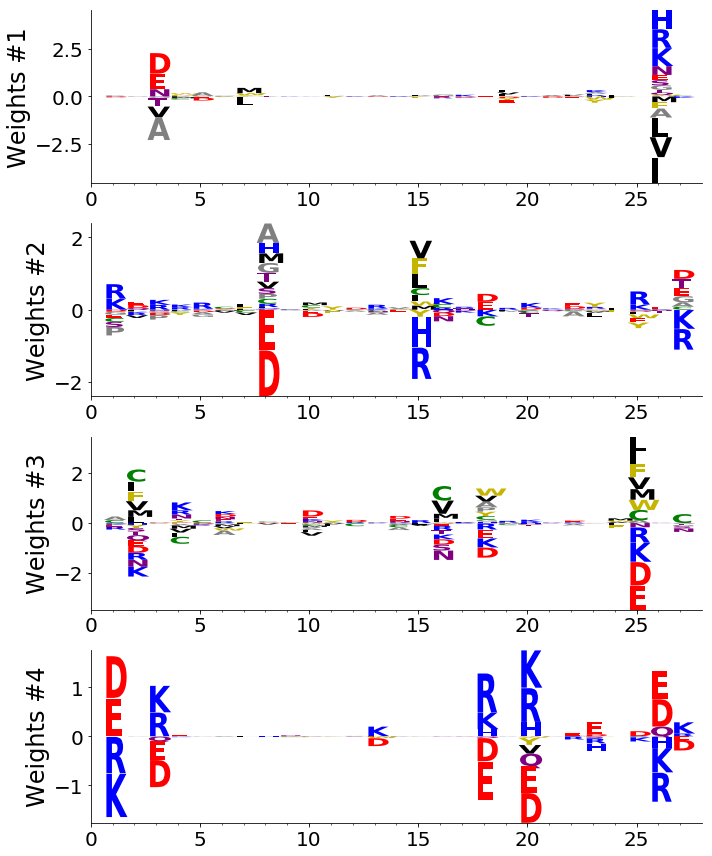

In [10]:
## Show some interesting features.

if make_training:
    interesting_features = [74,  1, 45, 21]
else:
    beta = Proteins_RBM_utils.get_beta(RBM.weights)
    order = np.argsort(beta)[::-1]    
    interesting_features = order[[9,49,52,29]]

nsites = len(interesting_features)
fig = sequence_logo.Sequence_logo_multiple(RBM.weights[interesting_features], figsize=(10,3) ,ticks_every=5,ticks_labels_size=20,title_size=24);


## Visualizing hidden units: Distribution of inputs and non-linearity.
Protein sequences cluster according to the projections onto the weights.

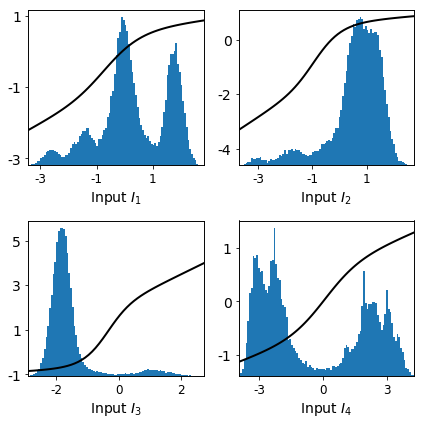

In [11]:
## Display their histograms of activations.

I = RBM.input_hiddens(all_data) # compute hidden unit input.
# Show inputs histogram and conditional means
plots_utils.plot_input_mean(RBM,I, interesting_features,ncols=2); 

## Visualizing hidden units: Phylogenic activity.
Are the features active across all, or only a portion of the phylogenic tree ? To assess this, we pick for each hidden unit the 20 sequences with highest $I_\mu$ (or lowest, depending on the sign of the non-linearity), and compute the distances between each pair. We compare to the background distribution of pairwise distances

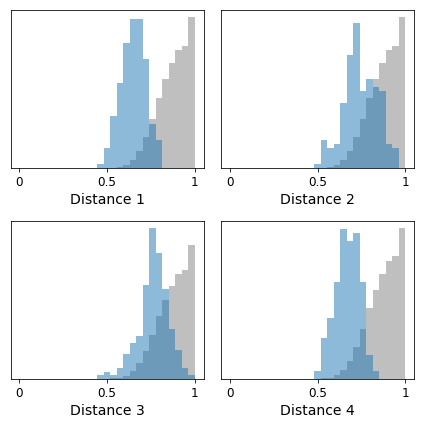

In [12]:
# Compute histogram of distances between top-activating sequences.
plots_utils.plot_top_activating_distance(RBM, I,all_data,interesting_features,ncols=2);

## Script for visualizing all hidden units into a single PDF. 
Requires  pdfjoin

In [ ]:
# Make all the previous plots, for all hidden units into a same pdf. Requires the utility pdfjoin.
plots_utils.make_all_weights(RBM,all_data,nweights = 10, weights=None,name = 'all_weights_LP.pdf',figsize=(15,3),sort='beta',dpi=200);

## Sampling from trained RBM.
Combining low-temperature sampling (with the duplicate RBM trick)  and conditional sampling allows to generate high-quality sequences with combinations of features unseen in the MSA.
Here, sequences with $I_2<<0$ or $I_3>>0$ are very rare, so the combination of both is almost unseen due to finite sampling. RBM can generate sequences with both.

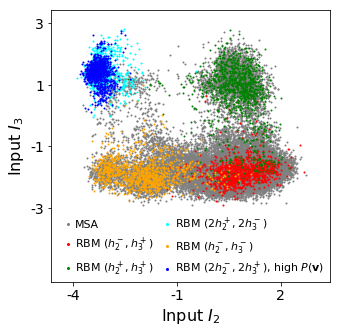

In [13]:
## We are conditioning on features 2 and 3. 


if make_training:
    bound1 = -2.5 # Trained RBM
    bound2 = 2
else:
    bound1 = -2.5 # Loaded RBM
    bound2 = -2

    
    
# First, get values for conditioning from histogram of mean activity. 
# We want to condition on the peaks of the histogram. 
# To find them, we split the histogram in two manually (using bound1/bound2), then find the highest counts on the left and right sides.
# Hidden unit 3 has a single peak, so the other value is chosen "arbitrary".



h = RBM.hlayer.mean_from_inputs(I)

histo =np.histogram(h[:,interesting_features[1]],bins=100);
count = histo[0]
interval = (histo[1][:-1]+histo[1][1:])/2
val_neg1 =  interval[interval<bound1][np.argmax(count[interval<bound1])]
val_pos1 =  interval[interval>bound1][np.argmax(count[interval>bound1])]


histo =np.histogram(h[:,interesting_features[2]],bins=100);
count = histo[0]
interval = (histo[1][:-1]+histo[1][1:])/2
val_neg2 =  interval[interval<bound2][np.argmax(count[interval<bound2])]
val_pos2 =  interval[interval>bound2][np.argmax(count[interval>bound2])]


# Define conditions, as a list of tuples (index, value)
if make_training:
    cond1 = [(interesting_features[1],val_neg1), (interesting_features[2],val_neg2) ]
    cond2 = [(interesting_features[1],val_neg1*2), (interesting_features[2],val_pos2*2) ] # Almost unseen combination in data
else:
    cond1 = [(interesting_features[1],val_neg1*2), (interesting_features[2],val_neg2*2) ] # Almost unseen combination in data
    cond2 = [(interesting_features[1],val_neg1), (interesting_features[2],val_pos2) ]

cond3 = [(interesting_features[1],val_pos1), (interesting_features[2],val_neg2) ]
cond4 = [(interesting_features[1],val_pos1), (interesting_features[2],val_pos2) ]
    

# The conditional distribution is equivalent to an RBM with M-2 hidden units. We construct them first.
condRBM1 = Proteins_RBM_utils.conditioned_RBM(RBM,cond1)
condRBM2 = Proteins_RBM_utils.conditioned_RBM(RBM,cond2)
condRBM3 = Proteins_RBM_utils.conditioned_RBM(RBM,cond3)
condRBM4 = Proteins_RBM_utils.conditioned_RBM(RBM,cond4)

# condRBM1,2,3,4 are RBM with M-2 hidden units, and fields = fields_RBM + \sum_{mu'} W_\mu' h_\mu', where mu' are the conditioning indexes.


# Use condRBM to generate sequences.
N_sequences = 1000 # Total number of sequences.
Nstep = 10 # Number of Monte Carlo steps between each update.

datav,datah = RBM.gen_data(Nchains = 100, Lchains = N_sequences/100,Nthermalize=500)

datav1,datah1 = condRBM1.gen_data(Nchains = 100, Lchains = N_sequences/100,Nthermalize=500)

datav2,datah2 = condRBM2.gen_data(Nchains = 100, Lchains = N_sequences/100,Nthermalize=500)

datav3,datah3 = condRBM3.gen_data(Nchains = 100, Lchains = N_sequences/100,Nthermalize=500)

datav4,datah4 = condRBM4.gen_data(Nchains = 100, Lchains = N_sequences/100,Nthermalize=500)

# Generate sequences at low temperature using the duplicate RBM trick.
datav_lowT,datah_lowT = Proteins_RBM_utils.gen_data_lowT(RBM, beta=2,Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,Nthermalize=500)

if make_training:
    datav2_lowT,datah2_lowT = Proteins_RBM_utils.gen_data_lowT(condRBM2, beta=2,Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,Nthermalize=500)
else:
    datav1_lowT,datah1_lowT = Proteins_RBM_utils.gen_data_lowT(condRBM1, beta=2,Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,Nthermalize=500)


# Visualize the sequences in the I_2 X I_3 plane.
I_ = RBM.input_hiddens(datav)
I1 = RBM.input_hiddens(datav1)
I2 = RBM.input_hiddens(datav2)
I3 = RBM.input_hiddens(datav3)
I4 = RBM.input_hiddens(datav4)


I_lowT = RBM.input_hiddens(datav_lowT)
if make_training:
    I2_lowT = RBM.input_hiddens(datav2_lowT)
else:
    I1_lowT = RBM.input_hiddens(datav1_lowT)




colors = ['grey','red','orange','cyan','green','blue']

s1 = 1.0
fig, ax = plt.subplots()
fig.set_figwidth(5)
fig.set_figheight(5)
i = 1
j = 2
ix = interesting_features[i]
iy = interesting_features[j]
ax.scatter(I[:,ix],I[:,iy],c=colors[0],s=s1,label='MSA')
ax.scatter(I3[:,ix],I3[:,iy],c=colors[1],s=s1,label=r'RBM $(h_{%s}^-,h_{%s}^+)$'%(2,3))
ax.scatter(I4[:,ix],I4[:,iy],c=colors[4],s=s1,label=r'RBM $(h_{%s}^+,h_{%s}^+)$'%(2,3))


if make_training:
    ax.scatter(I2[:,ix],I2[:,iy],c=colors[3],s=s1,label=r'RBM $(2h_{%s}^+,2h_{%s}^-)$'%(2,3))
    ax.scatter(I1[:,ix],I1[:,iy],c=colors[2],s=s1,label=r'RBM $(h_{%s}^-,h_{%s}^-)$'%(2,3))
    ax.scatter(I2_lowT[:,ix],I2_lowT[:,iy],c=colors[-1],s=s1,label=r'RBM $(2h_{%s}^-,2h_{%s}^+)$, high $P({\bf v})$'%(2,3))
    
else:
    ax.scatter(I2[:,ix],I2[:,iy],c=colors[2],s=s1,label=r'RBM $(h_{%s}^+,h_{%s}^-)$'%(2,3))
    ax.scatter(I1[:,ix],I1[:,iy],c=colors[3],s=s1,label=r'RBM $(2h_{%s}^-,2h_{%s}^-)$'%(2,3))
    ax.scatter(I1_lowT[:,ix],I1_lowT[:,iy],c=colors[-1],s=s1,label=r'RBM $(2h_{%s}^-,2h_{%s}^+)$, high $P({\bf v})$'%(2,3))


xmin = I[:,ix].min()* 1.25
xmax = I[:,ix].max()* 1.25
ax.set_xlim([xmin,xmax])
step = int( (xmax-xmin )/4.0) +1
xticks = np.arange(int(xmin), int(xmax)+1, step)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize=14)


ymin = I[:,iy].min() * 1.25
ymax = I[:,iy].max()* 1.25
ax.set_ylim([ymin-1.75,ymax])
step = int( (ymax-ymin )/4.0) +1
yticks = np.arange(int(ymin), int(ymax)+1, step)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize=14)    

ax.set_xlabel('Input $I_2$',fontsize=16)
ax.set_ylabel('Input $I_3$',fontsize=16)

plt.legend(ncol=2,fontsize=11,frameon=False,handletextpad=-0.3,markerscale=2,columnspacing=0.25,loc='center',bbox_to_anchor = (0.5,0.13))


## Proximity with sequences from the alignment.
A good generative model should produce sequences that are reasonibly far away from the training set. Conversely, sequences that are too far away should have low likelihood and a trade-off exists.

For each generated sequence, we compute its likelihood and distance to the closest natural sequence.


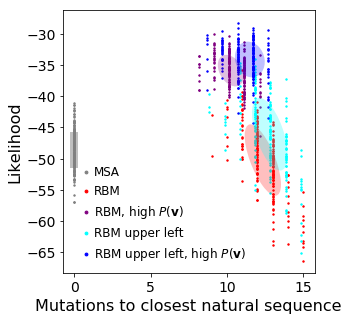

In [14]:
# ## Visualize likelihood vs distance to closest sequence.

from matplotlib import patches

def distance_to_natural(synth_seq,nat_seq): # For each seq in synth_seq, compute the distance to the closest natural sequence 
    min_dists = []
    for seq in synth_seq:
        min_dists.append ((seq[np.newaxis,:] <> nat_seq).mean(1).min() )
    return np.array(min_dists)



nmax = 200
N = 27

subset_nat = np.argsort(np.random.rand(data.shape[0]))[:nmax]
subset_synth = np.argsort(np.random.rand(datav.shape[0]))[:nmax]


d_synth = distance_to_natural(datav,all_data)
d_synth_lowT = distance_to_natural(datav_lowT,all_data)
if make_training:
    d_synth2 = distance_to_natural(datav2,all_data)
    d_synth2_lowT = distance_to_natural(datav2_lowT,all_data)
    lik_synth2 = RBM.likelihood(datav2)
    lik_synth2_lowT = RBM.likelihood(datav2_lowT)    
    
else:
    d_synth1 = distance_to_natural(datav1,all_data)
    d_synth1_lowT = distance_to_natural(datav1_lowT,all_data)
    lik_synth1 = RBM.likelihood(datav1)
    lik_synth1_lowT = RBM.likelihood(datav1_lowT)    

    
lik_nat = RBM.likelihood(all_data)
lik_synth = RBM.likelihood(datav)
lik_synth_lowT = RBM.likelihood(datav_lowT)



s1 = 14
s2 = 16
s3 = 2
s4 =12


off = 0.15

fig , ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)
fig.subplots_adjust(left=0.2,bottom=0.15)
plt.scatter(np.zeros(nmax), lik_nat[subset_nat], marker='o', s = s3, c = 'gray',label='MSA');
plt.scatter(d_synth[subset_synth]*N, lik_synth[subset_synth], marker='o', s = s3, c = 'red',label='RBM');
plt.scatter(d_synth_lowT[subset_synth]*N+off, lik_synth_lowT[subset_synth], marker='o', s = s3, c = 'purple',label=r'RBM, high $P({\bf v})$')
if make_training:
    plt.scatter(d_synth2[subset_synth]*N-off, lik_synth2[subset_synth], marker='o', s = s3, c = 'cyan',label=r'RBM upper left')
    plt.scatter(d_synth2_lowT[subset_synth]*N-2*off, lik_synth2_lowT[subset_synth], marker='o', s = s3, c = 'blue',label=r'RBM upper left, high $P({\bf v})$')
else:
    plt.scatter(d_synth1[subset_synth]*N-off, lik_synth1[subset_synth], marker='o', s = s3, c = 'cyan',label=r'RBM lower left')
    plt.scatter(d_synth1_lowT[subset_synth]*N-2*off, lik_synth1_lowT[subset_synth], marker='o', s = s3, c = 'blue',label=r'RBM lower left, high $P({\bf v})$')


mu = lik_nat.mean()
std = lik_nat.std()
w = 0.5

rec = patches.Rectangle(xy=(-w/2, mu-std),
              width=w, height=2*std)
rec.set_facecolor('gray')
rec.set_alpha(0.5)
ax.add_artist(rec)


mu_dists = (d_synth*N).mean()
mu_lik = lik_synth.mean()
covariance = np.cov(d_synth*N,  lik_synth )

lam,v = np.linalg.eigh(covariance)

ell = patches.Ellipse(xy=(mu_dists, mu_lik),
              width=np.sqrt(lam)[0]*2, height=np.sqrt(lam)[1]*2,
              angle=np.rad2deg(-np.arccos(v[0, 0])))
ell.set_facecolor('red')
ell.set_alpha(0.25)
ax.add_artist(ell)

mu_dists = (d_synth_lowT*N).mean()
mu_lik = lik_synth_lowT.mean()
covariance = np.cov(d_synth_lowT*N,  lik_synth_lowT )

lam,v = np.linalg.eigh(covariance)

ell = patches.Ellipse(xy=(mu_dists, mu_lik),
              width=np.sqrt(lam)[0]*2, height=np.sqrt(lam)[1]*2,
              angle=np.rad2deg(-np.arccos(v[0, 0])))
ell.set_facecolor('purple')
ell.set_alpha(0.25)
ax.add_artist(ell)

if make_training:
    mu_dists = (d_synth2*N).mean()
    mu_lik = lik_synth2.mean()
    covariance = np.cov(d_synth2*N,  lik_synth2 )
else:
    mu_dists = (d_synth1*N).mean()
    mu_lik = lik_synth1.mean()
    covariance = np.cov(d_synth1*N,  lik_synth1 )

lam,v = np.linalg.eigh(covariance)

ell = patches.Ellipse(xy=(mu_dists, mu_lik),
              width=np.sqrt(lam)[0]*2, height=np.sqrt(lam)[1]*2,
              angle=np.rad2deg(-np.arccos(v[0, 0])))
ell.set_facecolor('cyan')
ell.set_alpha(0.25)
ax.add_artist(ell)

if make_training:
    mu_dists = (d_synth2_lowT*N).mean()
    mu_lik = lik_synth2_lowT.mean()
    covariance = np.cov(d_synth2_lowT*N,  lik_synth2_lowT )
else:
    mu_dists = (d_synth1_lowT*N).mean()
    mu_lik = lik_synth1_lowT.mean()
    covariance = np.cov(d_synth1_lowT*N,  lik_synth1_lowT )    
    
lam,v = np.linalg.eigh(covariance)

ell = patches.Ellipse(xy=(mu_dists, mu_lik),
              width=np.sqrt(lam)[0]*2, height=np.sqrt(lam)[1]*2,
              angle=np.rad2deg(-np.arccos(v[0, 0])))
ell.set_facecolor('blue')
ell.set_alpha(0.25)
ax.add_artist(ell)

x = [0,5,10,15]
ax.set_xticks(x)
ax.set_xticklabels(x,fontsize=s1);
ax.set_xlabel('Mutations to closest natural sequence',fontsize=s2)
ax.set_ylabel('Likelihood',fontsize=s2)


for tl in ax.get_xticklabels():
    tl.set_fontsize(s1)
for tl in ax.get_yticklabels():
    tl.set_fontsize(s1)    
plt.legend(fontsize=s4,frameon=False,loc='lower left',markerscale=2,handletextpad=-0.3);


